In [1]:
import torch
from src.training.funsd import _funsd
import torch.nn as nn
from src.paths import CHECKPOINTS
from src.models.VGAE import GAE, GSage_AE
from src.data.Data_Loaders import FUNSD_loader

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = FUNSD_loader(train=True)

{   'FEATURES': {   'add_embs': True,
                    'add_eweights': True,
                    'add_fudge': True,
                    'add_geom': True,
                    'add_hist': True,
                    'add_visual': True,
                    'num_polar_bins': 8},
    'GRAPHS': {   'data_type': 'img',
                  'edge_type': 'fully',
                  'node_granularity': 'gt'},
    'LOADER': {   'src_data': 'FUNSD'}}


TRAIN


adding features: 100%|██████████| 149/149 [01:00<00:00,  2.47it/s]


In [3]:
data.get_info()


FUNSD TRAIN dataset:
-> graphs: 149
-> node labels: ['answer' 'header' 'other' 'question']
-> edge labels: ['none' 'pair']
-> node features: 1756
-> edge type: fully
-> textual feats: True
-> visual feats: True
-> edge feats: True
-> graph example: Graph(num_nodes=104, num_edges=10712,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(1756,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})


In [4]:
from typing import Tuple
def discrete_positions(rect_src : list, rect_dst : list) -> Tuple[int, int]:
    """Compute distance and angle from src to dst bounding boxes (poolar coordinates considering the src as the center)
    Args:
        rect_src (list) : source rectangle coordinates
        rect_dst (list) : destination rectangle coordinates
    
    Returns:
        tuple (ints): distance and angle
    """
    
    # check relative position
    left = (rect_dst[2] - rect_src[0]) <= 0
    bottom = (rect_src[3] - rect_dst[1]) <= 0
    right = (rect_src[2] - rect_dst[0]) <= 0
    top = (rect_dst[3] - rect_src[1]) <= 0
    
    vp_intersect = (rect_src[0] <= rect_dst[2] and rect_dst[0] <= rect_src[2]) # True if two rects "see" each other vertically, above or under
    hp_intersect = (rect_src[1] <= rect_dst[3] and rect_dst[1] <= rect_src[3]) # True if two rects "see" each other horizontally, right or left
    rect_intersect = vp_intersect and hp_intersect
    
    if rect_intersect:
        return 0 #'intersect'
    elif top and left:
        return 1 #'top_left'
    elif left and bottom:
        return 2 #'bottom_left'
    elif bottom and right:
        return 3 #'bottom_right'
    elif right and top:
        return 4 #'top_right'
    elif left:
        return 5 #'left'
    elif right:
        return 6 #'right'
    elif bottom:
        return 7 #'bottom'
    elif top:
        return 8 #'top'  
    
    #number2_position = {0:'intersect', 1:'top_left', 2:'bottom_left', 3:'bottom_right', 4:'top_right', 5:'left', 6:'right', 7:'bottom', 8:'top'}

In [5]:
def get_relative_positons(graphs):

    for graph in graphs:
        src, dst = graph.edges()
        discret_info = []
        for src_idx, dst_idx in zip(src, dst):
            src_idx = src_idx.item()
            dst_idx = dst_idx.item()
            relative_position = discrete_positions(graph.nodes[src_idx][0]['geom'][0], graph.nodes[dst_idx][0]['geom'][0])
            discret_info.append(relative_position)
        graph.edata['discrete_info'] = torch.tensor(discret_info)
    return graphs

In [6]:
from sklearn.model_selection import train_test_split
from dgl.data.utils import save_graphs, load_graphs
import dgl
import pickle

train_graphs, val_graphs, _, _ = train_test_split(data.graphs, torch.ones(len(data.graphs), 1), test_size=0.2, random_state=42)

#Graph for training
train_graphs = get_relative_positons(train_graphs)
train_graph = dgl.batch(train_graphs)
train_graph = train_graph.int()

with open('./src/train_graph.pkl', 'wb') as f:
    pickle.dump(train_graph, f)

In [7]:
#Graph for validating
val_graph = get_relative_positons(val_graphs)
val_graph = dgl.batch(val_graphs)
val_graph = val_graph.int()

#Saved validation graph
with open('./src/val_graph.pkl', 'wb') as f:
    pickle.dump(val_graph, f)

In [4]:
file = open("/home/nbiescas/Desktop/CVC/CVC_internship/src/train_graph.pkl",'rb')

In [5]:
import pickle
object_file = pickle.load(file)
file.close()


In [9]:
glist, label_dict = load_graphs("./src/train_graph.bin")

In [17]:
glist[0].edata['discrete_info']

tensor([6, 4, 1,  ..., 6, 3, 3])

In [4]:
def get_discrete_positions(data):
    discrete_info_number = {'right': 0, 'left': 1, 'down': 2, 'up': 3, 'down_right': 4, 'down_left': 5, 'up_right': 6, 'up_left': 7}

    for graph in data.graphs:
        discret_info = []
        for idx, node in enumerate(graph.ndata['geom']):
            xmin, ymin, _, _ = node
            for idx2, node2 in enumerate(graph.ndata['geom']):
                if idx == idx2:
                    continue
                xmin2, ymin2, _, _ = node2
                sector = ""
                
                offset_y = ymin * 0.1
                offset_x = xmin * 0.1

                if ((ymin - offset_y)  < ymin2)  and (ymin2< (ymin + offset_y)):
                    if xmin < xmin2:
                        sector += 'right'
                    else:
                        sector += 'left'

                elif ((xmin - offset_x) < xmin2) and (xmin2 < (xmin + offset_x)):
                    if ymin < ymin2:
                        sector += 'down'
                    else:
                        sector += 'up'
                else:
                    if ymin < ymin2:
                        sector += "down_"
                    else:
                        sector += "up_"

                    if xmin < xmin2:
                        sector += "right"  
                    else:
                        sector += "left"

                discret_info.append(discrete_info_number[sector])
        graph.edata['discrete_info'] = torch.tensor(discret_info)
        
    return data

In [8]:
data.graphs[1].ndata.keys()

dict_keys(['geom', 'feat', 'norm', 'label'])

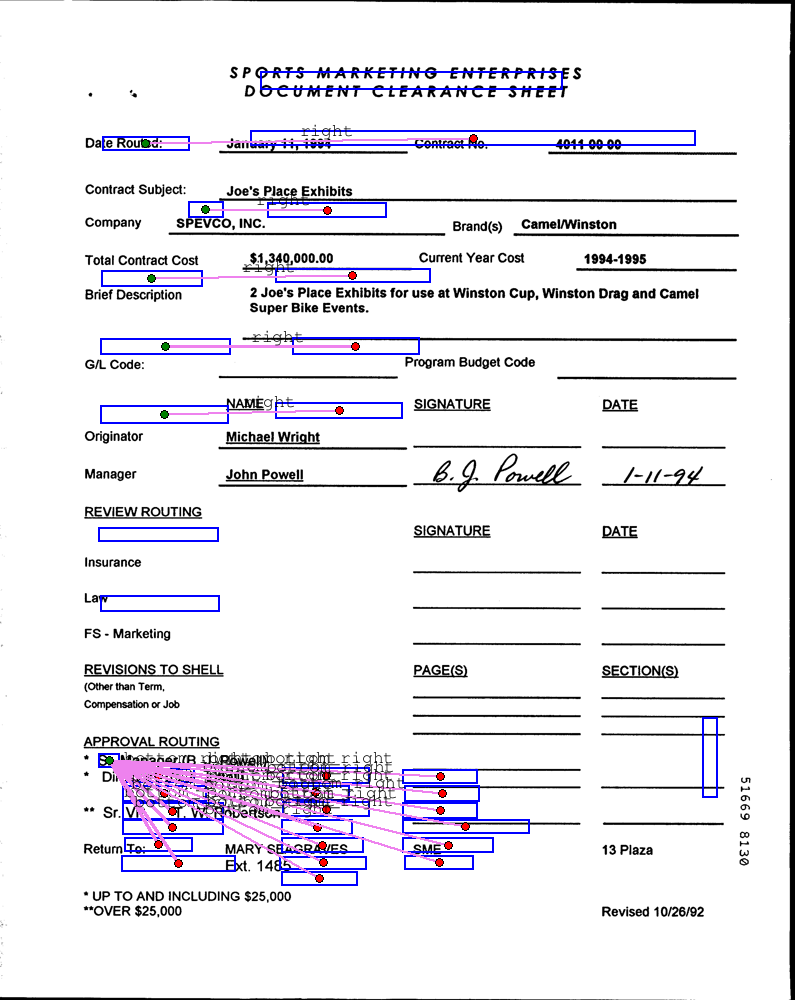

In [16]:
num = 28
import dgl
data.print_graph(graph=dgl.unbatch(object_file)[num], num=num)

In [13]:
torch.min(graph.ndata['geom'], dim=0)

torch.return_types.min(
values=tensor([0.1247, 0.0210, 0.1845, 0.0380]),
indices=tensor([ 0, 20,  0,  2]))

In [ ]:
graph.ndata[]

In [20]:
import dgl
import numpy as np


real_edges = graph.edata['label'].nonzero().squeeze(1)
E = len(real_edges)
mask_rates = torch.FloatTensor(np.ones(E) * 0.8)
masks = torch.bernoulli(mask_rates)
mask_idx = masks.nonzero().squeeze(1)
pos = real_edges[mask_idx]

graph2 = dgl.remove_edges(graph, pos.type(torch.int32)), pos

In [17]:
graph.edata['label'].shape

torch.Size([2756])

In [22]:
graph2[0].edata['label'].shape

torch.Size([2735])

In [116]:
torch.where(graph.edata['label'] == 1)[0].__len__()

25

In [119]:
import numpy as np
import dgl

real_edges = graph.edata['label'].nonzero().squeeze(1)
E = len(real_edges)

#E = graph.num_edges()
mask_rates = torch.FloatTensor(np.ones(E) * 1)
masks = torch.bernoulli(mask_rates)
mask_idx = masks.nonzero().squeeze(1) # Edges that we keep

pos = real_edges[mask_idx]
print(pos.shape)
dgl.remove_edges(graph, pos.type(torch.int32))


torch.Size([25])


Graph(num_nodes=53, num_edges=2731,
      ndata_schemes={'geom': Scheme(shape=(4,), dtype=torch.float32), 'feat': Scheme(shape=(1756,), dtype=torch.float32), 'norm': Scheme(shape=(1,), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'feat': Scheme(shape=(6,), dtype=torch.float32), 'weights': Scheme(shape=(), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64)})

In [100]:
pos.type(torch.int32)

tensor([1996, 2164, 5357, 5873, 6491, 7427, 7462, 7463, 7548, 7551, 7554, 7736,
        9176, 9177, 9324], dtype=torch.int32)

In [91]:
new_src


tensor([1995, 2000, 2063, 2579, 3517, 5355, 6491, 6652, 7429, 7456, 7457, 7460,
        7552, 7553, 7554, 7556, 7736, 9125, 9175, 9322, 9323])

In [83]:
new_dst = torch.cat((new_dst, dst_inveted), dim = 0)
new_src = torch.cat((new_src, src_invented), dim = 0)
import dgl
dgl.graph((new_src, new_dst))

Graph(num_nodes=103, num_edges=20879,
      ndata_schemes={}
      edata_schemes={})

In [48]:
real_edges

tensor([1958, 1963, 1994, 1995, 1996, 2000, 2001, 2002, 2063, 2064, 2164, 2579,
        3414, 3517, 3624, 5355, 5356, 5357, 5443, 5873, 5976, 6079, 6491, 6594,
        6652, 6963, 7066, 7169, 7421, 7422, 7423, 7424, 7425, 7426, 7427, 7428,
        7429, 7455, 7456, 7457, 7458, 7459, 7460, 7461, 7462, 7463, 7548, 7549,
        7550, 7551, 7552, 7553, 7554, 7555, 7556, 7736, 7783, 7886, 9124, 9125,
        9172, 9173, 9174, 9175, 9176, 9177, 9320, 9321, 9322, 9323, 9324, 9325,
        9326, 9327])

In [31]:
data.graphs[0].edata['label']

idx = data.graphs[0].edata['label'].nonzero().squeeze(1)
src = src[idx]

In [38]:
l = data.graphs[0].edata['label'].nonzero().squeeze(1)

In [40]:
src = data.graphs[0].edges()[0]
dst = data.graphs[0].edges()[1]

In [39]:
data.graphs[0].edata['label'][l]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1])

In [7]:
import numpy as np
mask_rates = torch.FloatTensor(np.ones(10) * 0.5)
masks = torch.bernoulli(1 - mask_rates)

In [89]:
dgl.remove_edges(data.graphs[0], l)

DGLError: Expect argument "u" to have data type torch.int32. But got torch.int64.

In [12]:
masks.nonzero().squeeze(1)

tensor([0, 2, 3, 5])

In [1]:
data.edge_num_classes

NameError: name 'data' is not defined

In [6]:
import dgl
dgl.batch(data.graphs).ndata['feat'].shape

torch.Size([7406, 4])

In [7]:
a = dgl.batch(data.graphs).edata['weights']

In [14]:
import torch

# Assuming you have your tensor as 'input_tensor'
input_tensor = torch.randn(100, 3, 56)  # Replace this with your actual tensor

# Reshape the tensor to (100, 168)
output_tensor = input_tensor.view((input_tensor.size()[0], (input_tensor.size()[2] * 3)))# OR
# output_tensor = input_tensor.reshape(100, 168)

# Verify the shape
print(output_tensor.shape)


torch.Size([100, 168])


In [2]:
#Load the data
test_data = FUNSD_loader(train=True)

{   'FEATURES': {   'add_embs': True,
                    'add_eweights': True,
                    'add_fudge': True,
                    'add_geom': True,
                    'add_hist': True,
                    'add_visual': True,
                    'num_polar_bins': 8},
    'GRAPHS': {   'data_type': 'img',
                  'edge_type': 'fully',
                  'node_granularity': 'gt'},
    'LOADER': {   'src_data': 'FUNSD'}}




adding features: 100%|██████████| 149/149 [00:58<00:00,  2.55it/s]


In [3]:
# Load the weights of the model
layers_dimensions = (1756, 400, 200, 100)
model = GSage_AE(layers_dimensions)
state_dict = torch.load(CHECKPOINTS / 'qualitative_results.pth')
model.load_state_dict(state_dict)


Encoder: ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=1756, out_features=1756, bias=True)
    (fc_self): Linear(in_features=1756, out_features=400, bias=False)
    (fc_neigh): Linear(in_features=1756, out_features=400, bias=False)
  )
  (1): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=400, out_features=400, bias=True)
    (fc_self): Linear(in_features=400, out_features=200, bias=False)
    (fc_neigh): Linear(in_features=400, out_features=200, bias=False)
  )
  (2): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=200, out_features=200, bias=True)
    (fc_self): Linear(in_features=200, out_features=100, bias=False)
    (fc_neigh): Linear(in_features=200, out_features=100, bias=False)
  )
) 	Numb Layers: 4

Decoder: ModuleList(
  (0): SAGEConv(
    (feat_drop): Dropout(p=0.0, inplace=False)
    (fc_pool): Linear(in_features=100, out_fe

<All keys matched successfully>

In [4]:
# Graph to try
import dgl
graphs = dgl.batch(test_data.graphs)

# Send to the gpu
criterion = torch.nn.MSELoss()
model = model.to('cuda:0')
graphs = graphs.to('cuda:0')
feat  = graphs.ndata['feat'].to('cuda:0')

In [5]:
graphs.ndata['label'].unique()

tensor([0, 1, 2, 3], device='cuda:0')

In [6]:
# Calculate the prediction values
pred = model(graphs, feat)

### Emedding Visualization

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import dgl

def extract_embeddings(loader, model):
    model = model.to('cuda:0')
    graph = dgl.batch(loader.graphs).to('cuda:0')
    h = graph.ndata['feat'].to('cuda:0')
    for layer in model.encoder:
        h = layer(graph, h)
    
    val_embeddings = h
    labels = graph.ndata['label']
    return val_embeddings.cpu().detach().numpy(), labels.cpu().detach().numpy()
    
val_embeddings, labels = extract_embeddings(test_data, model)

t_sne = TSNE(n_components = 2, perplexity=45, n_iter=1000, init="pca")    
S_t_sne = t_sne.fit_transform(val_embeddings)


/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



In [26]:
fashion_mnist_classes = ["answer", "header", "other", "question"]
colors = ['#1f77b4', '#000000', '#2ca02c', '#d62728']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i], s=2)
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(fashion_mnist_classes)
    

In [35]:
import torch
from src.models.Drop_edge import E2E
import math
layers_dimensions = (1756, 600, 400, 100)
edge_pred_features = int((math.log2(8) + data.node_num_classes)*2)
model = E2E(node_classes = data.node_num_classes, 
                    edge_classes = data.edge_num_classes, 
                    dimensions_layers = layers_dimensions, 
                    dropout=0.2, 
                    edge_pred_features=edge_pred_features,
                    drop_rate = 0).to('cuda:0')

model.load_state_dict(torch.load(CHECKPOINTS / 'Run_2.pth'))

<All keys matched successfully>

In [37]:
 ["on top of", "vertically near", "horizontally near"]

ImportError: cannot import name 'compute_auc_mc' from 'src.evaluation' (/home/nbiescas/Desktop/CVC/CVC_internship/src/evaluation.py)

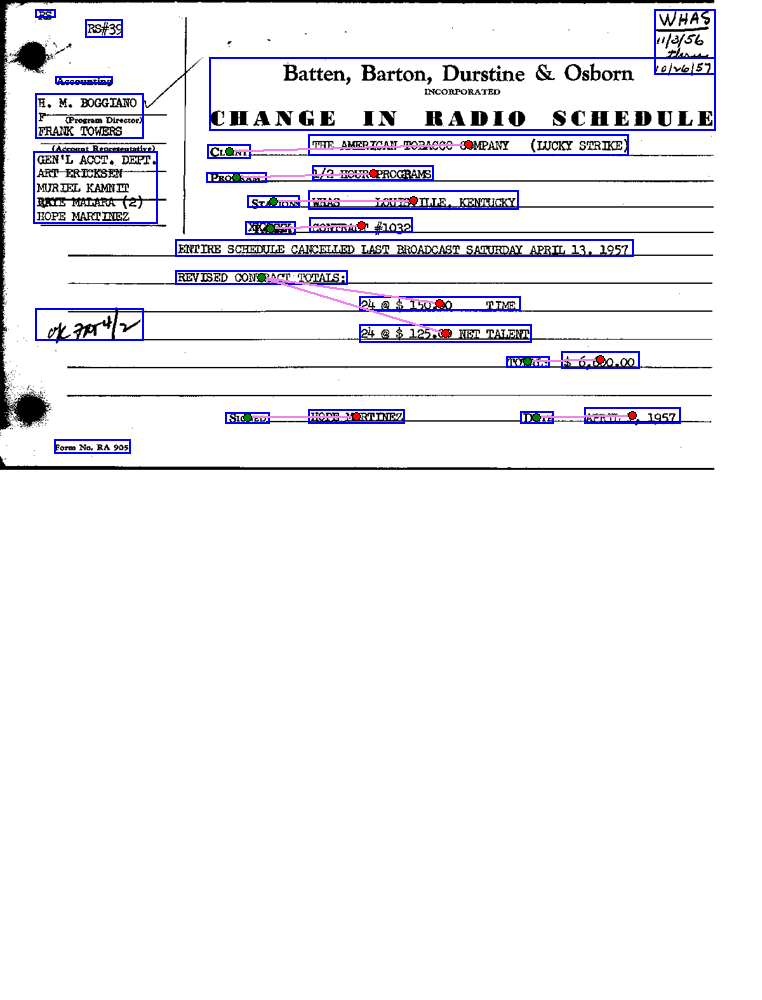

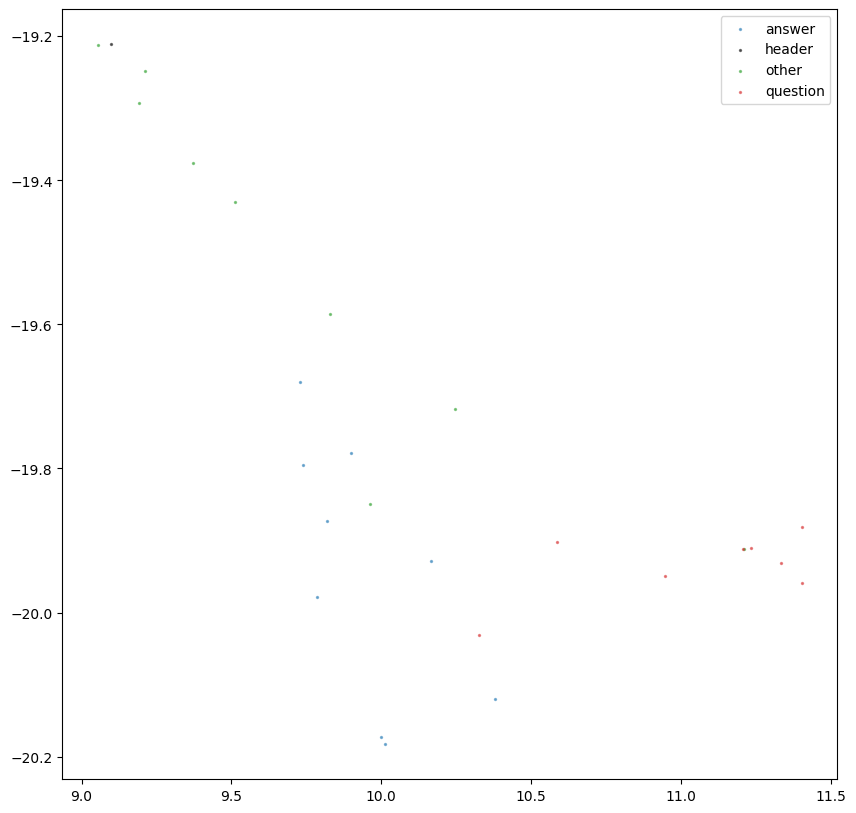

In [27]:
start = 0
num = 22
for i in range(num):
    start += test_data.graphs[i].num_nodes()

end = start + test_data.graphs[num].num_nodes()
test_data.graphs[num].num_nodes()
plot_embeddings(S_t_sne[start:end], labels[start:end])
test_data.print_graph(num)

In [1]:
import torch

/home/nbiescas/miniconda3/envs/doc2graph/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
l = torch.tensor([[6,7,8,9,10], [5, 5, 5, 6, 7]])
s = torch.tensor([[1,2,3,4,5], [2,3,4,5,6]])
torch.cat((l, s), dim=1)

tensor([[ 6,  7,  8,  9, 10,  1,  2,  3,  4,  5],
        [ 5,  5,  5,  6,  7,  2,  3,  4,  5,  6]])

In [2]:
from sklearn.cluster import KMeans
import numpy as np


a = np.random.rand(100, 2)

In [4]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(a)

In [20]:
a = kmeans.labels_
counts = np.bincount(a)
print(np.argmax(counts))

0


In [19]:
np.where(kmeans.labels_ == 0)[0]

array([ 6, 12, 14, 20, 27, 30, 37, 42, 45, 46, 48, 49, 51, 52, 56, 57, 59,
       61, 64, 65, 67, 69, 72, 73, 74, 78, 79, 84, 90, 92, 94])